# Redes Neurais - Projeto de Análise de Crédito

Alunos: Jonathan Kilner, Luiz Antônio e Matheus Leon

In [1]:
%pip install optuna
%pip install imbalanced-learn
%pip install xgboost
%pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import optuna
import gc
import imblearn
import xgboost as xgb
import scikitplot as skplt

# Leitura dos dados

In [3]:
data_path = './TRNcod.xls'

In [4]:
df = pd.read_csv(data_path, sep='\t', encoding='utf-8')

In [5]:
df.head()

,INDEX,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
0,0,1,1,1,0,0,0,0,0.135098,1,...,0,0,1,1,0,1,1,1,0,1
1,1,1,0,1,0,0,1,0,0.273504,1,...,0,1,0,1,1,0,0,0,1,0
2,2,1,0,1,0,0,1,0,0.281910,0,...,1,1,0,0,0,0,1,0,1,0
3,3,1,1,1,0,0,0,0,0.225741,0,...,1,1,0,1,1,0,1,0,1,0
4,4,1,1,0,0,0,1,0,0.480403,0,...,1,1,1,0,0,1,0,1,1,0


In [6]:
df.drop(['INDEX'], axis=1, inplace=True)

#### Combinando classes em uma única coluna

In [7]:
def label_class (row):
   if row['IND_BOM_1_1'] == 1 and row['IND_BOM_1_2'] == 1:
      return 2
   if row['IND_BOM_1_1'] == 1:
      return 0
   if row['IND_BOM_1_2'] == 1:
      return 1
   return 3

In [8]:
df['class'] = df.apply (lambda row: label_class(row), axis=1)

In [9]:
df.head()

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2,class
0,1,1,1,0,0,0,0,0.135098,1,0.222222,...,0,1,1,0,1,1,1,0,1,1
1,1,0,1,0,0,1,0,0.273504,1,0.111111,...,1,0,1,1,0,0,0,1,0,0
2,1,0,1,0,0,1,0,0.281910,0,1.000000,...,1,0,0,0,0,1,0,1,0,0
3,1,1,1,0,0,0,0,0.225741,0,0.111111,...,1,0,1,1,0,1,0,1,0,0
4,1,1,0,0,0,1,0,0.480403,0,0.111111,...,1,1,0,0,1,0,1,1,0,0


In [10]:
print('classe 0:', len(df[df['class'] == 0]))
print('classe 1:', len(df[df['class'] == 1]))
print('classe desconhecida:', len(df[df['class'] > 1]))

classe 0: 255098
classe 1: 134098
classe desconhecida: 0


# Particionamento dos dados

### Particionamento dos dados - 1ª Etapa

In [11]:
x_class_0 = df[df['class'] == 0]
x_class_1 = df[df['class'] == 1]

In [12]:
x_class_0.head()

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2,class
1,1,0,1,0,0,1,0,0.273504,1,0.111111,...,1,0,1,1,0,0,0,1,0,0
2,1,0,1,0,0,1,0,0.281910,0,1.000000,...,1,0,0,0,0,1,0,1,0,0
3,1,1,1,0,0,0,0,0.225741,0,0.111111,...,1,0,1,1,0,1,0,1,0,0
4,1,1,0,0,0,1,0,0.480403,0,0.111111,...,1,1,0,0,1,0,1,1,0,0
5,0,1,1,0,0,0,1,0.219323,0,0.111111,...,1,1,0,1,0,0,1,1,0,0


In [13]:
x_class_1.head()

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2,class
0,1,1,1,0,0,0,0,0.135098,1,0.222222,...,0,1,1,0,1,1,1,0,1,1
10,1,0,1,1,0,0,0,0.654703,0,0.111111,...,1,0,1,0,0,0,0,0,1,1
11,1,1,1,0,0,0,0,0.097444,1,0.111111,...,1,0,1,0,1,0,1,0,1,1
12,1,0,1,0,1,0,0,0.398961,0,0.111111,...,1,1,0,1,0,0,0,0,1,1
17,1,1,1,0,0,0,0,0.142254,0,0.111111,...,0,0,1,0,1,0,1,0,1,1


### Particionamento dos dados - 2ª Etapa

In [14]:
y_class_0 = x_class_0['class'].values
y_class_1 = x_class_1['class'].values

### Particionamento dos dados - 3ª Etapa

Os dados foram divididos aleatoriamente usando o método train_test_split()
- 50% dos dados para treinamento
- Dos 50% restantes, metade(25% do total) pra validação e o restante(25%) para teste

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train_class_0, X_rem_class_0, y_train_class_0, y_rem_class_0 = train_test_split(x_class_0, y_class_0, train_size=0.5)
X_valid_class_0, X_test_class_0, y_valid_class_0, y_test_class_0 = train_test_split(X_rem_class_0, y_rem_class_0, test_size=0.5)

In [17]:
X_train_class_1, X_rem_class_1, y_train_class_1, y_rem_class_1 = train_test_split(x_class_1, y_class_1, train_size=0.5)
X_valid_class_1, X_test_class_1, y_valid_class_1, y_test_class_1 = train_test_split(X_rem_class_1, y_rem_class_1, test_size=0.5)

Concatenamos os dados das duas classes para todos os conjuntos.

In [18]:
X_train = pd.concat([X_train_class_0, X_train_class_1])
y_train = np.concatenate((y_train_class_0, y_train_class_1))
X_train = X_train.drop(['class', 'IND_BOM_1_1', 'IND_BOM_1_2'], axis=1)

In [19]:
X_valid = pd.concat([X_valid_class_0, X_valid_class_1])
y_valid = np.concatenate((y_valid_class_0, y_valid_class_1))
X_valid = X_valid.drop(['class', 'IND_BOM_1_1', 'IND_BOM_1_2'], axis=1)

In [20]:
X_test = pd.concat([X_test_class_0, X_test_class_1])
y_test = np.concatenate((y_test_class_0, y_test_class_1))
X_test = X_test.drop(['class', 'IND_BOM_1_1', 'IND_BOM_1_2'], axis=1)

In [21]:
print('Quantidade de entradas para treino:', len(X_train), len(y_train))
print('Quantidade de entradas para validação:', len(X_valid), len(y_valid))
print('Quantidade de entradas para teste:', len(X_test), len(y_test))

Quantidade de entradas para treino: 194598 194598
Quantidade de entradas para validação: 97298 97298
Quantidade de entradas para teste: 97300 97300


### Oversampling - Replicar a classe minoritária para ficar do tamanho da classe majoritária

In [22]:
print('Quantidade antes do over sampling')
print('Quantidade classe 0 treino:', (y_train == 0).sum())
print('Quantidade classe 1 treino:', (y_train == 1).sum())
print('Quantidade classe 0 valid:', (y_valid == 0).sum())
print('Quantidade classe 1 valid:', (y_valid == 1).sum())
print('Quantidade classe 0 test:', (y_test == 0).sum())
print('Quantidade classe 1 test:', (y_test == 1).sum())

Quantidade antes do over sampling
Quantidade classe 0 treino: 127549
Quantidade classe 1 treino: 67049
Quantidade classe 0 valid: 63774
Quantidade classe 1 valid: 33524
Quantidade classe 0 test: 63775
Quantidade classe 1 test: 33525


In [23]:
from imblearn.over_sampling import SMOTE

Vamos utilizar a biblioteca imblearn para fazer o oversampling.

Para isso usamos a função SMOTE() que cria por padrão novos dados sintéticos para a classe minoritária.

In [24]:
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [25]:
print('Quantidade classe 0 treino:', (y_train == 0).sum())
print('Quantidade classe 1 treino:', (y_train == 1).sum())

Quantidade classe 0 treino: 127549
Quantidade classe 1 treino: 127549


In [26]:
oversample = SMOTE()
X_valid, y_valid = oversample.fit_resample(X_valid, y_valid)

In [27]:
print('Quantidade classe 0 valid:', (y_valid == 0).sum())
print('Quantidade classe 1 valid:', (y_valid == 1).sum())

Quantidade classe 0 valid: 63774
Quantidade classe 1 valid: 63774


In [28]:
print('Quantidade classe 0 test:', (y_test == 0).sum())
print('Quantidade classe 1 test:', (y_test == 1).sum())

Quantidade classe 0 test: 63775
Quantidade classe 1 test: 33525


# Funções auxiliares para métricas

Métricas utilizadas:

- Teste estatístico Kolmogorov-Smirnov (KS)

- Acurácia

- Recall

- Precision

- F1-Score

- Auroc (Área sob a Curva Roc)

- Matriz de confusão
      [TP  FP]
      [FN  TN]

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, RocCurveDisplay

from scipy.stats import ks_2samp

import matplotlib
import matplotlib.pyplot as plt

In [31]:
def plot_ks_statistic(y, y_pred_scores=None):
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()

In [32]:
def plot_roc_curve(actual, pred_proba):
    skplt.metrics.plot_roc(actual, pred_proba)
    plt.show()

In [33]:
def print_metrics(actual, pred, pred_proba):
    print('Accuracy: {:.4f}'.format(accuracy_score(actual, pred)))
    print('Recall: {:.4f}'.format(recall_score(actual, pred)))
    print('Precision: {:.4f}'.format(precision_score(actual, pred)))
    print('F1-Score: {:.4f}'.format(f1_score(actual, pred)))
    print('ROC AUC Score: {:.4f}'.format(roc_auc_score(actual, pred_proba[:, 1])))
    print('Matriz de confusão no conjunto de teste:')
    print(confusion_matrix(actual, pred))
    plot_ks_statistic(actual, pred_proba)
    plot_roc_curve(actual, pred_proba)

In [117]:
def eval_metrics(actual, pred):
    accuracy = accuracy_score(actual, pred)
    recall = recall_score(actual, pred)
    precision = precision_score(actual, pred)
    f1 = f1_score(actual, pred)
    return accuracy, recall, precision, f1

In [116]:
def eval_ks_metric(actual, pred):
    df = pd.DataFrame()
    df['real'] = actual
    df['proba'] = pred[:, 1]
    
    # Recover each class
    class0 = df[df['real'] == 0]
    class1 = df[df['real'] == 1]
    ks_stat = ks_2samp(class0['proba'], class1['proba'])
    return ks_stat.statistic

# Algoritmos

In [194]:
n_trials=100

### Modelo MLP

Descrição dos principais parâmetros:

 - hidden_layer_sizes: tupla, comprimento da camada oculta. O padrão é (100,), o que significa uma única camada oculta com 100 neurônios.

 - activation: função de ativação para a camada oculta. Os valores possíveis são ‘identity’, ‘logistic’, ‘tanh’, ‘relu’. O padrão é ‘relu’.

 - learning_rate_init: a taxa de aprendizado inicial para ‘sgd’ ou ‘adam’. O padrão é 0,001. Nota: a taxa de aprendizado é sempre modificada para ‘learning_rate_init’ quando ‘learning_rate’ é definido como ‘invscaling’ ou ‘adaptive’.

In [37]:
from sklearn.neural_network import MLPClassifier

1ª Configuração

In [38]:
mlp_clf = MLPClassifier()

In [39]:
%%time
mlp_clf.fit(X_train, y_train)

CPU times: total: 20min 11s
Wall time: 6min 13s


c:\Users\jonat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [185]:
y_mlp_pred_test_1st = mlp_clf.predict(X_test)
y_mlp_pred_test_proba_1st = mlp_clf.predict_proba(X_test)

Accuracy: 0.6437
Recall: 0.4510
Precision: 0.4818
F1-Score: 0.4659
ROC AUC Score: 0.6476
Matriz de confusão no conjunto de teste:
[[47512 16263]
 [18405 15120]]


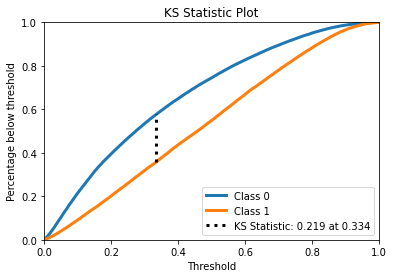

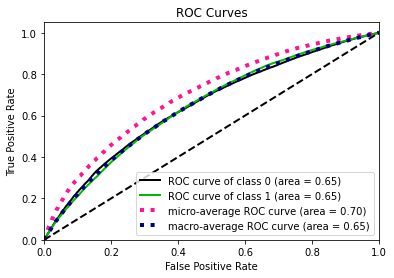

In [186]:
print_metrics(y_test, y_mlp_pred_test_1st, y_mlp_pred_test_proba_1st)

2ª Configuração - Optuna

In [123]:
def mlp_fn(trial):
  # Define the search space
    params = {
        'learning_rate_init': trial.suggest_float('learning_rate_init', 0.001, 0.1, step=0.001),
        'first_layer_neurons': trial.suggest_int('first_layer_neurons', 10, 100, step=10),
        'second_layer_neurons': trial.suggest_int('second_layer_neurons', 10, 100, step=10),
        'activation': trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh',  'relu'])
    }

    mlp_reg = MLPClassifier(
        hidden_layer_sizes=(params['first_layer_neurons'], params['second_layer_neurons']),
        learning_rate_init=params['learning_rate_init'],
        activation=params['activation'],
        random_state=42
    )

    mlp_reg.fit(X_train, y_train)

    y_pred_valid_proba = mlp_reg.predict_proba(X_valid)

    statistic = eval_ks_metric(y_valid, y_pred_valid_proba)

    gc.collect()

    return statistic

In [130]:
mlp_study = optuna.create_study(direction="maximize")

[I 2022-10-15 00:18:41,819] A new study created in memory with name: no-name-69581b05-51bb-44ce-9c39-919877233857


In [195]:
mlp_study.optimize(mlp_fn, n_trials=n_trials)

c:\Users\jonat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2022-10-15 11:54:26,626] Trial 10 finished with value: 0.4205632389374981 and parameters: {'learning_rate_init': 0.001, 'first_layer_neurons': 100, 'second_layer_neurons': 40, 'activation': 'relu'}. Best is trial 3 with value: 0.4630100040768966.
c:\Users\jonat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
[I 2022-10-15 11:55:19,384] Trial 11 finished with value: 0.46379402264245617 and parameters: {'learning_rate_init': 0.002, 'first_layer_neurons': 70, 'second_layer_neurons': 50, 'activation': 'tanh'}. Best is trial 11 with value: 0.46379402264245617.
[I 2022-10-15 11:55:52,353] Trial 12 finished with value: 0.43600840467902285

In [196]:
mlp_study.best_params

{'learning_rate_init': 0.005,
 'first_layer_neurons': 70,
 'second_layer_neurons': 80,
 'activation': 'relu'}

In [197]:
def mlp_test(params):
    mlp_reg = MLPClassifier(
        hidden_layer_sizes=(params['first_layer_neurons'], params['second_layer_neurons']),
        learning_rate_init=params['learning_rate_init'],
        activation=params['activation'],
        random_state=42
    )

    mlp_reg.fit(X_train, y_train)

    y_pred_test = mlp_reg.predict(X_test)
    y_pred_test_proba = mlp_reg.predict_proba(X_test)

    print_metrics(y_test, y_pred_test, y_pred_test_proba)

    gc.collect()

    return y_pred_test, y_pred_test_proba

Accuracy: 0.6661
Recall: 0.4522
Precision: 0.5177
F1-Score: 0.4827
ROC AUC Score: 0.6847
Matriz de confusão no conjunto de teste:
[[49653 14122]
 [18365 15160]]


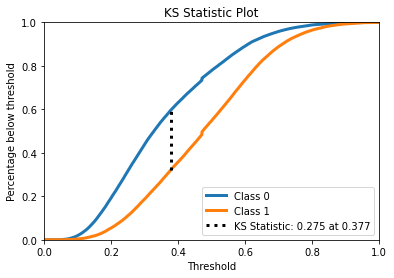

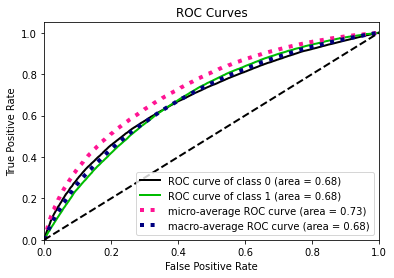

In [198]:
y_pred_test_mlp, y_pred_test_proba_mlp = mlp_test(mlp_study.best_params)

### Modelo Random Forest

Descrição dos parâmetros:

- n_estimators
  - O número de árvores na floresta.

- criterion
  - A função para medir a qualidade de uma divisão

- max_depth
  - A profundidade máxima da árvore.
  - 'None' significa que os nós são expandidos até que todas as folhas sejam puras(se o nó possui prediz apenas 1 classe) ou até que todas as folhas contenham menos de min_samples_split amostras.

- min_samples_split
  - O número mínimo de amostras necessárias para dividir um nó.

- min_samples_leaf
  - O número mínimo de amostrar necessárias para ser um nó folha.

- max_features
  - O número de features a serem considerados ao procurar a melhor divisão. Por exemplo, caso a função seja 'sqrt', a cada divisão ele tenta buscar uma condição que possua sqrt(n_node) entradas. 

- max_leaf_nodes
  - O número max de nós folha. 
  - 'None' significa então pode haver um número ilimitado de nós folha.

In [48]:
from sklearn.ensemble import RandomForestClassifier

#### 1ª Configuração

A primeira configuração é utilizada com os parâmetros padrões do Sklearn.

Segue abaixo a lista dos principais hiperparâmetros:

- n_estimators = 100

- criterion = 'gini'

- max_depth = None 

- min_samples_split = 2

- min_samples_leaf = 1

- max_features = 'sqrt'

- max_leaf_nodes = None

In [49]:
clf_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [50]:
%%time
history_rf = clf_rf.fit(X_train, y_train)

CPU times: total: 5min 45s
Wall time: 33.1 s


In [187]:
y_test_pred_rf_1st = clf_rf.predict(X_test)

In [188]:
y_test_proba_rf_1st = clf_rf.predict_proba(X_test)

##### 1a Análise de Desempenho

Accuracy: 0.6715
Recall: 0.3834
Precision: 0.5324
F1-Score: 0.4458
ROC AUC Score: 0.6837
Matriz de confusão no conjunto de teste:
[[52485 11290]
 [20671 12854]]


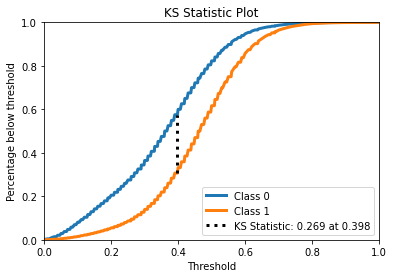

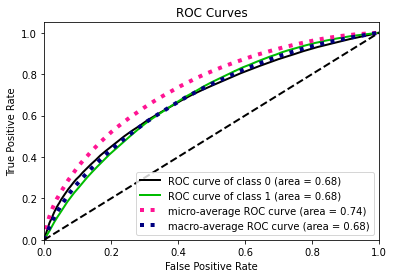

In [189]:
print_metrics(y_test, y_test_pred_rf_1st, y_test_proba_rf_1st)

#### 2ª Configuração

Para a segunda configuração vamos criar um estudo de caso usando o optuna, variando alguns hiperparâmetros

In [199]:
def random_forest(trial):
    params = {
        'n_estimators':  trial.suggest_int('n_estimators', 30, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 10000),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 1, 10000)
    }
    # Create the model
    rnd_forest = RandomForestClassifier(
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        max_leaf_nodes=params["max_leaf_nodes"],
        random_state=0,
        n_jobs=-1
    )

    rnd_forest.fit(X_train, y_train)

    y_pred_proba = rnd_forest.predict_proba(X_valid)

    statistic = eval_ks_metric(y_valid, y_pred_proba)

    gc.collect()

    return statistic

In [200]:
rf_study = optuna.create_study(direction="maximize")

[I 2022-10-15 16:02:15,956] A new study created in memory with name: no-name-daddbb0c-97e2-4627-b665-73bea3019dd5


In [201]:
%%time
rf_study.optimize(random_forest, n_trials=n_trials)

[I 2022-10-15 16:04:13,745] Trial 0 finished with value: 0.4916423620911343 and parameters: {'n_estimators': 415, 'max_depth': 2709, 'max_leaf_nodes': 7073}. Best is trial 0 with value: 0.4916423620911343.
[I 2022-10-15 16:07:21,592] Trial 1 finished with value: 0.49187756766080215 and parameters: {'n_estimators': 667, 'max_depth': 7348, 'max_leaf_nodes': 7019}. Best is trial 1 with value: 0.49187756766080215.
[I 2022-10-15 16:10:28,194] Trial 2 finished with value: 0.4921441339730925 and parameters: {'n_estimators': 667, 'max_depth': 704, 'max_leaf_nodes': 6872}. Best is trial 2 with value: 0.4921441339730925.
[I 2022-10-15 16:14:59,521] Trial 3 finished with value: 0.49114059020917616 and parameters: {'n_estimators': 934, 'max_depth': 2133, 'max_leaf_nodes': 9525}. Best is trial 2 with value: 0.4921441339730925.
[I 2022-10-15 16:17:42,739] Trial 4 finished with value: 0.48954119233543447 and parameters: {'n_estimators': 670, 'max_depth': 7615, 'max_leaf_nodes': 1781}. Best is trial 2

CPU times: total: 2d 19h 50min 24s
Wall time: 6h 3min 41s


In [202]:
rf_study.best_params

{'n_estimators': 996, 'max_depth': 9367, 'max_leaf_nodes': 4003}

In [203]:
def random_forest_test(params):
    rnd_forest = RandomForestClassifier(
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        max_leaf_nodes=params["max_leaf_nodes"],
        random_state=0,
        n_jobs=-1
    )

    rnd_forest.fit(X_train, y_train)

    y_pred_test = rnd_forest.predict(X_test)
    y_pred_test_proba = rnd_forest.predict_proba(X_test)
    
    print_metrics(y_test, y_pred_test, y_pred_test_proba)

    return y_pred_test, y_pred_test_proba

Accuracy: 0.6816
Recall: 0.4199
Precision: 0.5496
F1-Score: 0.4761
ROC AUC Score: 0.7015
Matriz de confusão no conjunto de teste:
[[52240 11535]
 [19447 14078]]


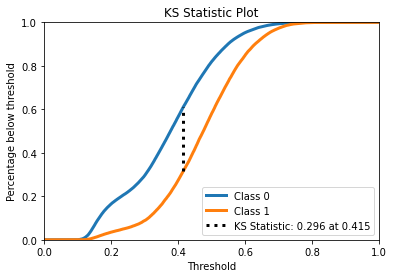

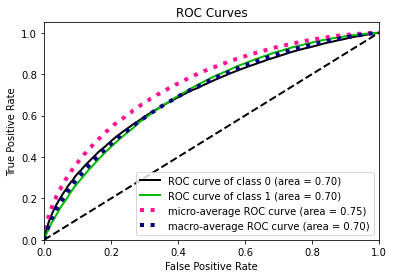

In [204]:
y_pred_test_rf, y_pred_test_proba_rf = random_forest_test(rf_study.best_params)

### Modelo SVM

Descrição dos principais parâmetros:

- C
  - Parâmetro de regularização. A força da regularização é inversamente proporcional a C. Deve ser estritamente positiva. A penalidade é uma penalidade de 12 ao quadrado.

- kernel
  - Especifica o tipo de kernel a ser usado no algoritmo. Se nenhum for fornecido, 'rbf' será usado. Se um callable for fornecido, ele será usado para pré-computar a matriz do kernel a partir de matrizes de dados; essa matriz deve ser uma matriz de forma
  - Valor default: rbf

- degree
  - Grau da função kernel polinomial ('poli'). Ignorado por todos os outros kernels.
  - Valor default: 3

- gamma
  - Coeficiente de kernel para 'rbf', 'poli' e 'sigmóide'


In [61]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [62]:
clf_svm = SVC(gamma='auto', probability=True)

In [63]:
# %%time
clf_svm.fit(X_train, y_train)

SVC(gamma='auto', probability=True)

In [64]:
y_test_pred_svm = clf_svm.predict(X_test)

In [65]:
y_test_proba_svm = clf_svm.predict_proba(X_test)

##### Análise de Desempenho

Métricas da 1ª configuração do SVM:

Accuracy: 0.6642
Recall: 0.3760
Precision: 0.5175
F1-Score: 0.4355
ROC AUC Score: 0.6694
Matriz de confusão no conjunto de teste:
[[52025 11750]
 [20921 12604]]


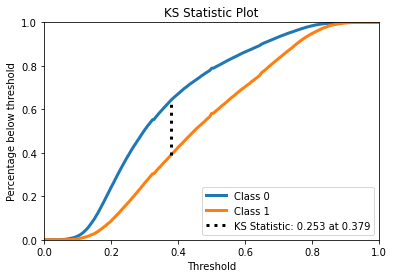

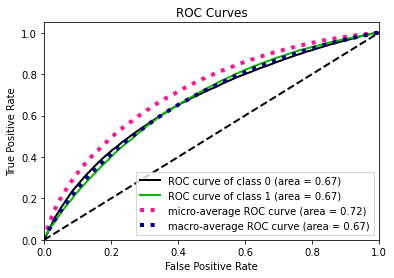

In [68]:
print('Métricas da 1ª configuração do SVM:\n')
print_metrics(y_test, y_test_pred_svm, y_test_proba_svm)

### Ensemble de MLP

In [73]:
from sklearn.ensemble import BaggingClassifier

In [205]:
params_ens = mlp_study.best_params

ens_mlp = MLPClassifier(
        hidden_layer_sizes=(params_ens['first_layer_neurons'], params_ens['second_layer_neurons']),
        learning_rate_init=params_ens['learning_rate_init'],
        activation=params_ens['activation'],
        random_state=42
    )

In [206]:
mlp_ens_clf = BaggingClassifier(base_estimator=ens_mlp, n_estimators=100, random_state=0, n_jobs=-1)

In [207]:
mlp_ens_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=MLPClassifier(hidden_layer_sizes=(70, 80),
                                               learning_rate_init=0.005,
                                               random_state=42),
                  n_estimators=100, n_jobs=-1, random_state=0)

In [208]:
y_mlp_ens_pred_test = mlp_ens_clf.predict(X_test)
y_mlp_ens_pred_test_proba = mlp_ens_clf.predict_proba(X_test)

Accuracy: 0.6767
Recall: 0.3870
Precision: 0.5433
F1-Score: 0.4520
ROC AUC Score: 0.6959
Matriz de confusão no conjunto de teste:
[[52869 10906]
 [20551 12974]]


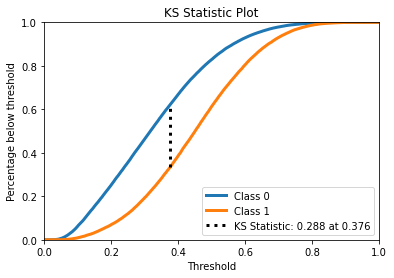

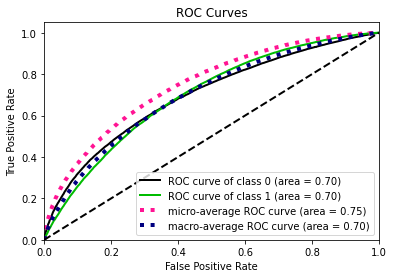

In [209]:
print_metrics(y_test, y_mlp_ens_pred_test, y_mlp_ens_pred_test_proba)

Accuracy: 0.6664
Recall: 0.4101
Precision: 0.5201
F1-Score: 0.4586
ROC AUC Score: 0.6788
Matriz de confusão no conjunto de teste:
[[51092 12683]
 [19777 13748]]


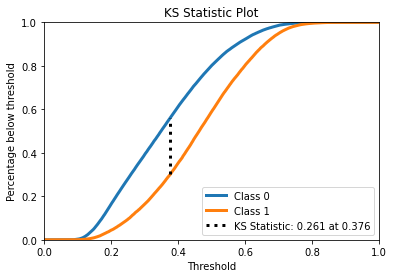

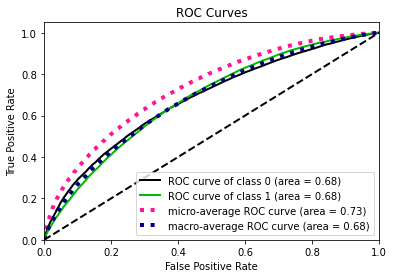

In [ ]:
print_metrics(y_test, y_mlp_ens_pred_test, y_mlp_ens_pred_test_proba)

### Modelo AdaBoost

Definição dos parâmetros
* base_estimator object, default=None
    * O estimador base a partir do qual o conjunto impulsionado é construído. É necessário suporte para ponderação de amostra, bem como atributos classes_ e n_classes_ apropriados. Se Nenhum, então o estimador base é DecisionTreeClassifier inicializado com max_depth=1.

* n_estimators int, default=50
    * O número máximo de estimadores em que o reforço é encerrado. Em caso de ajuste perfeito, o processo de aprendizagem é interrompido precocemente. Os valores devem estar no intervalo [1, inf).

* learning_rate float, default=1.0
    * Peso aplicado a cada classificador em cada iteração de reforço. Uma taxa de aprendizado mais alta aumenta a contribuição de cada classificador. Há um trade-off entre os parâmetros learning_rate e n_estimators. Os valores devem estar no intervalo (0,0, inf).

* algorithm {‘SAMME’, ‘SAMME.R’}, default=’SAMME.R’
    * Se 'SAMME.R', use o algoritmo de reforço real SAMME.R. base_estimator deve suportar o cálculo de probabilidades de classe. Se 'SAMME', use o algoritmo de reforço discreto SAMME. O algoritmo SAMME.R normalmente converge mais rápido que o SAMME, alcançando um erro de teste menor com menos iterações de reforço.

* random_state int, RandomState instance or None, default=None
    * Controla a semente aleatória fornecida em cada base_estimator em cada iteração de reforço. Assim, ele só é usado quando base_estimator expõe um random_state. Passe um int para saída reproduzível em várias chamadas de função. Consulte Glossário.

In [79]:
from sklearn.ensemble import AdaBoostClassifier

#### 1ª Configuração

A primeira configuração é utilizada com os parâmetros padrões do Sklearn.

Segue abaixo a lista dos principais hiperparâmetros:

- n_estimators = 100

- learning_rate = 1

- algorithm = SAMME.R

- random_state = 1


In [147]:
clf_adaBoost = AdaBoostClassifier(n_estimators=100, learning_rate = 1, random_state=0)

In [217]:
%%time
history_adaBoost = clf_adaBoost.fit(X_train, y_train)

CPU times: total: 4min 4s
Wall time: 4min 41s


In [218]:
y_test_pred_adaBoost = clf_adaBoost.predict(X_test)

In [219]:
y_test_proba_adaBoost = clf_adaBoost.predict_proba(X_test)

##### Análise de Desempenho

Métricas da 1ª configuração do Adaboost:

Accuracy: 0.6596
Recall: 0.4423
Precision: 0.5069
F1-Score: 0.4724
ROC AUC Score: 0.6744
Matriz de confusão no conjunto de teste:
[[49354 14421]
 [18698 14827]]


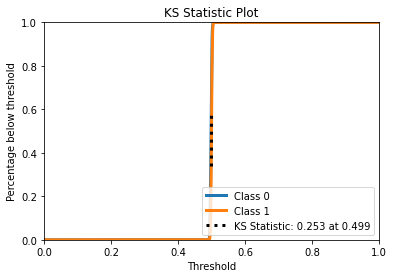

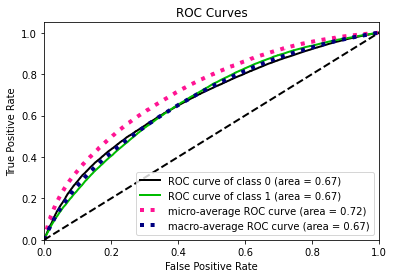

In [220]:
print('Métricas da 1ª configuração do Adaboost:\n')
print_metrics(y_test, y_test_pred_adaBoost, y_test_proba_adaBoost)

### Modelo Gradient Boosting

Descrição dos parâmetros:

- loss
  - Possíveis valores: ‘log_loss’, ‘exponential’
  - default=’log_loss’
  - A função de perda a ser otimizada. 
    - 'log_loss' refere-se ao desvio binomial e multinomial, o mesmo usado na regressão logística. É uma boa escolha para classificação com saídas probabilísticas. 
    - 'exponencial', o aumento de gradiente recupera o algoritmo AdaBoost.

- learning_rate
  - Possíveis valores: intervalo (0,0, inf)
  - default=0.1
  - A taxa de aprendizado reduz a contribuição de cada árvore por learning_rate. Há um trade-off entre learning_rate e n_estimators. 

- n_estimators
  - Os valores devem estar no intervalo [1, inf).
  - default=100
  - O número de estágios de reforço a serem executados. 
  - **O aumento de gradiente é bastante robusto ao over-fitting, portanto, um número grande geralmente resulta em melhor desempenho.

- subsample
  - Os valores devem estar no intervalo (0,0, 1,0].
  - default=1.0
  - A fração de amostras a ser usada para ajustar os 'individual base learners'. 
  - Se menor que 1,0, isso resulta em aumento de gradiente estocástico. subamostra interage com o parâmetro n_estimators. 
    - **Escolher subamostra < 1,0 leva a uma redução da variância e a um aumento no viés.

- criterion
  - Possíveis valores: {‘friedman_mse’, ‘squared_error’, ‘mse’}
  - default=’friedman_mse’
  - A função para medir a qualidade de uma divisão. 
  - Os critérios suportados são:
    - ‘friedman_mse’ para o erro quadrático médio com pontuação de melhoria por Friedman, 
    - ‘squared_error’ para erro quadrático médio. 
  - **O valor padrão de ‘friedman_mse’ geralmente é o melhor, pois pode fornecer uma melhor aproximação em alguns casos.

- min_samples_split
  - Possíveis valores: int or float
  - default=2
  - Se int, os valores devem estar no intervalo [1, inf).
  - Se float, os valores devem estar no intervalo (0.0, 1.0] e min_samples_leaf será ceil(min_samples_leaf * n_samples).

- min_samples_leaf
  - Possíveis valores: int or float
  - default=1
  - Isso pode ter o efeito de suavizar o modelo, especialmente na regressão.

- min_weight_fraction_leaf
  - Os valores devem estar no intervalo [0,0, 0,5].
  - default=0.0(As amostras têm peso igual)
  - A fração ponderada mínima da soma total de pesos (de todas as amostras de entrada) necessária para estar em um nó folha. 

- max_depth
  - Os valores devem estar no intervalo [1, inf).
  - default=3
  - Ajuste este parâmetro para melhorar o desempenho; 
    - O melhor valor depende da interação das variáveis de entrada.

- min_impurity_decrease
  - Os valores devem estar no intervalo [0,0, inf).
  - default=0.0
  - Um nó será dividido se esta divisão induzir uma diminuição da impureza maior ou igual a este valor.

- init
  - Possíveis valores: estimator or ‘zero’
  - default=None(é usado um DummyEstimator)
  - Um objeto estimador que é usado para calcular as previsões iniciais. 
  - init tem que fornecer fit e predict_proba. 
  - Se 'zero', as previsões brutas iniciais são definidas como zero. 

- max_features
  - Possíveis valores: {‘auto’, ‘sqrt’, ‘log2’}, int or float
    - Se int, valores devem estar no intervalo  [1, inf).
    - Se float, valores devem estar no intervalo  (0.0, 1.0] and the features considered at each split will be max(1, int(max_features * n_features_in_)).
    - Se f = ‘auto’, ‘sqrt’, ‘log2’, então max_features = f(n_features).
    - Se None, então max_features = n_features.
  - default=None
  - O número de features para considerar quando buscar pelo melhor split.



In [85]:
from sklearn.ensemble import GradientBoostingClassifier

#### 1ª Configuração

A primeira configuração é utilizada com os parâmetros padrões do Sklearn.

Segue abaixo a lista dos principais hiperparâmetros:

- loss
  - default=’log_loss’

- learning_rate
  - default=0.1

- n_estimators
  - default=100

- subsample
  - default=1.0

- criterion
  - default=’friedman_mse’

- min_samples_split
  - default=2

- min_samples_leaf
  - default=1

- min_weight_fraction_leaf
  - default=0.0(As amostras têm peso igual)

- max_depth
  - default=3

- min_impurity_decrease
  - default=0.0

- init
  - default=None(é usado um DummyEstimator)

- max_features
  - default=None(então max_features = n_features.)




In [86]:
clf_gb = xgb.XGBClassifier(random_state=27)

In [87]:
%%time
clf_gb.fit(X_train, y_train)

CPU times: total: 8min 55s
Wall time: 51 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=27,
              reg_alpha=0, reg_lambda=1, ...)

In [190]:
y_pred_gb_1st = clf_gb.predict(X_test)

In [191]:
y_proba_gb_1st = clf_gb.predict_proba(X_test)

##### Análise de Desempenho

Métricas da 1ª configuração do Random Forest:

Accuracy: 0.6875
Recall: 0.3868
Precision: 0.5684
F1-Score: 0.4603
ROC AUC Score: 0.7062
Matriz de confusão no conjunto de teste:
[[53929  9846]
 [20559 12966]]


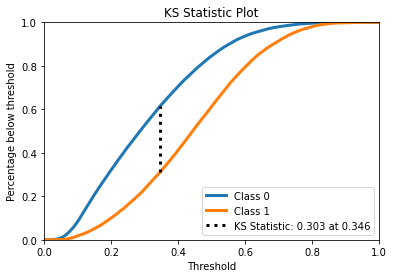

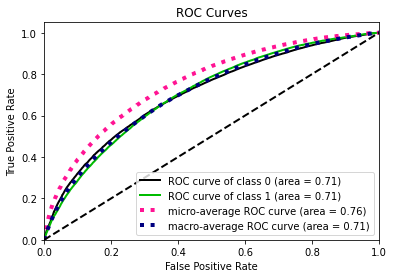

In [192]:
print('Métricas da 1ª configuração do Random Forest:\n')
print_metrics(y_test, y_pred_gb_1st, y_proba_gb_1st)

#### 2ª Configuração

Para a segunda configuração alteramos os seguintes parâmetros:

In [210]:
def gradient_boosting(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.0951, step=0.005),
        'max_depth': trial.suggest_int('max_depth', 4, 100),
        'n_estimators': trial.suggest_int('n_estimators', 100, 300, step=10)
    }

    gb_clf_trial = xgb.XGBClassifier(
        learning_rate=params["learning_rate"],
        max_depth=params["max_depth"],
        n_estimators=params["n_estimators"],
        random_state=42
    )
    gb_clf_trial.fit(X_train, y_train)

    y_pred_proba = gb_clf_trial.predict_proba(X_valid)

    statistic = eval_ks_metric(y_valid, y_pred_proba)

    gc.collect()

    return statistic

In [211]:
gb = optuna.create_study(direction="maximize")
gb.optimize(gradient_boosting, n_trials=n_trials)

[I 2022-10-16 02:46:31,554] A new study created in memory with name: no-name-6630c942-cfeb-41fb-9111-51e81415ba6a
[I 2022-10-16 02:59:49,987] Trial 0 finished with value: 0.5001881644557344 and parameters: {'learning_rate': 0.035100000000000006, 'max_depth': 61, 'n_estimators': 220}. Best is trial 0 with value: 0.5001881644557344.
[I 2022-10-16 03:08:44,157] Trial 1 finished with value: 0.49987455702951045 and parameters: {'learning_rate': 0.0601, 'max_depth': 64, 'n_estimators': 150}. Best is trial 0 with value: 0.5001881644557344.
[I 2022-10-16 03:21:25,396] Trial 2 finished with value: 0.5017248408442312 and parameters: {'learning_rate': 0.07010000000000001, 'max_depth': 66, 'n_estimators': 230}. Best is trial 2 with value: 0.5017248408442312.
[I 2022-10-16 03:31:30,806] Trial 3 finished with value: 0.49543701194844286 and parameters: {'learning_rate': 0.0301, 'max_depth': 61, 'n_estimators': 160}. Best is trial 2 with value: 0.5017248408442312.
[I 2022-10-16 03:47:45,790] Trial 4 f

In [212]:
gb.best_params

{'learning_rate': 0.0551, 'max_depth': 10, 'n_estimators': 210}

In [213]:
def gradient_boosting_test(params):

    gb_clf_trial = xgb.XGBClassifier(
        learning_rate=params["learning_rate"],
        max_depth=params["max_depth"],
        n_estimators=params["n_estimators"],
        random_state=42
    )
    gb_clf_trial.fit(X_train, y_train)

    y_pred_test = gb_clf_trial.predict(X_test)
    y_pred_test_proba = gb_clf_trial.predict_proba(X_test)

    print_metrics(y_test, y_pred_test, y_pred_test_proba)

    return y_pred_test, y_pred_test_proba

In [170]:
params = {'learning_rate': 0.040100000000000004, 'max_depth': 31, 'n_estimators': 300}

Accuracy: 0.6933
Recall: 0.3794
Precision: 0.5847
F1-Score: 0.4602
ROC AUC Score: 0.7143
Matriz de confusão no conjunto de teste:
[[54739  9036]
 [20804 12721]]


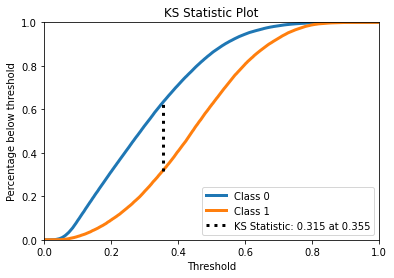

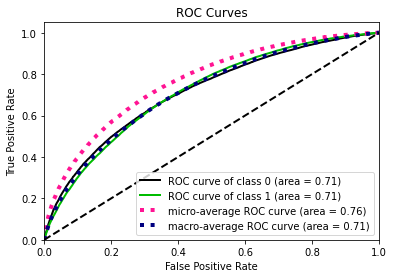

In [214]:
y_pred_test_gb, y_pred_test_proba_gb = gradient_boosting_test(gb.best_params)

## Comparação dos modelos

### 1ª Configuração

------MLP------
Accuracy: 0.6437
Recall: 0.4510
Precision: 0.4818
F1-Score: 0.4659
ROC AUC Score: 0.6476
Matriz de confusão no conjunto de teste:
[[47512 16263]
 [18405 15120]]


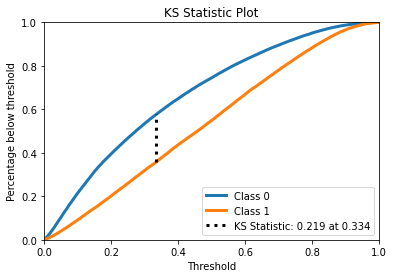

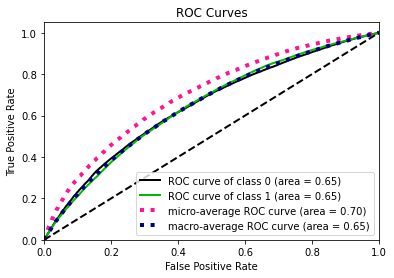

------Random Forest------
Accuracy: 0.6715
Recall: 0.3834
Precision: 0.5324
F1-Score: 0.4458
ROC AUC Score: 0.6837
Matriz de confusão no conjunto de teste:
[[52485 11290]
 [20671 12854]]


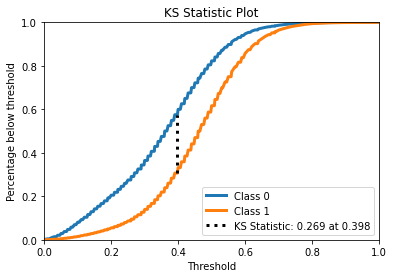

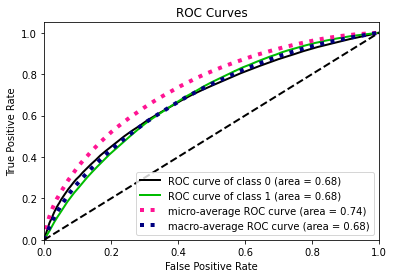

------Gradient Boosting------
Accuracy: 0.6875
Recall: 0.3868
Precision: 0.5684
F1-Score: 0.4603
ROC AUC Score: 0.7062
Matriz de confusão no conjunto de teste:
[[53929  9846]
 [20559 12966]]


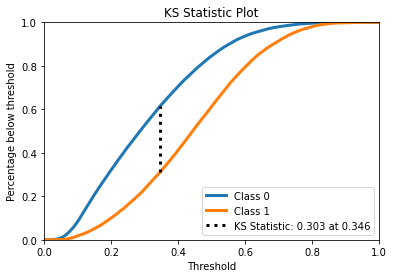

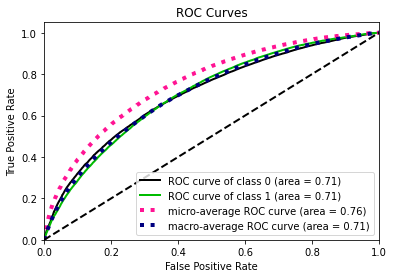

In [215]:
print("------MLP------")
print_metrics(y_test, y_mlp_pred_test_1st, y_mlp_pred_test_proba_1st)

print("------Random Forest------")
print_metrics(y_test, y_test_pred_rf_1st, y_test_proba_rf_1st)

print("------Gradient Boosting------")
print_metrics(y_test, y_pred_gb_1st, y_proba_gb_1st)

### 2ª Configuração

------MLP------
Accuracy: 0.6661
Recall: 0.4522
Precision: 0.5177
F1-Score: 0.4827
ROC AUC Score: 0.6847
Matriz de confusão no conjunto de teste:
[[49653 14122]
 [18365 15160]]


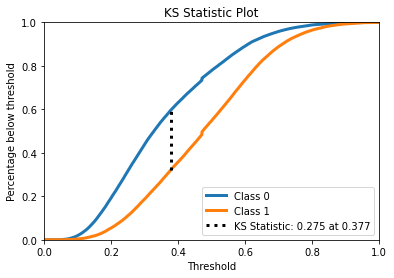

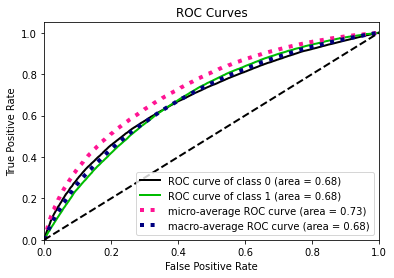

------SVM------
Accuracy: 0.6642
Recall: 0.3760
Precision: 0.5175
F1-Score: 0.4355
ROC AUC Score: 0.6694
Matriz de confusão no conjunto de teste:
[[52025 11750]
 [20921 12604]]


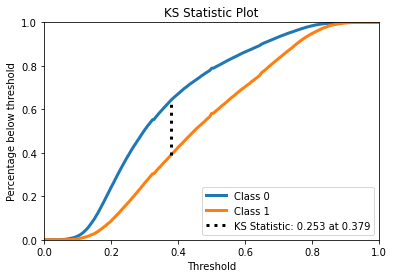

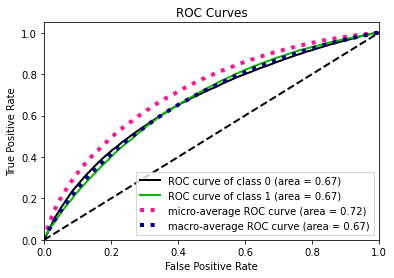

------Random Forest------
Accuracy: 0.6816
Recall: 0.4199
Precision: 0.5496
F1-Score: 0.4761
ROC AUC Score: 0.7015
Matriz de confusão no conjunto de teste:
[[52240 11535]
 [19447 14078]]


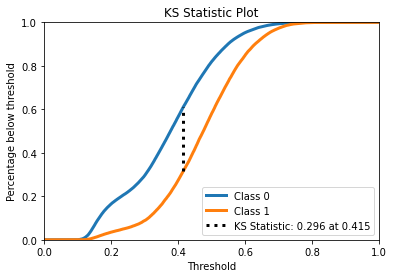

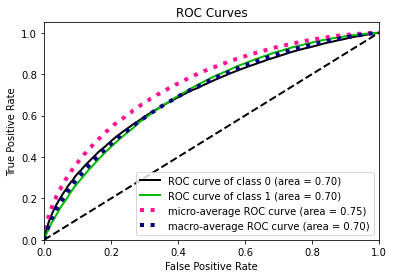

------Ensemble MLP------
Accuracy: 0.6767
Recall: 0.3870
Precision: 0.5433
F1-Score: 0.4520
ROC AUC Score: 0.6959
Matriz de confusão no conjunto de teste:
[[52869 10906]
 [20551 12974]]


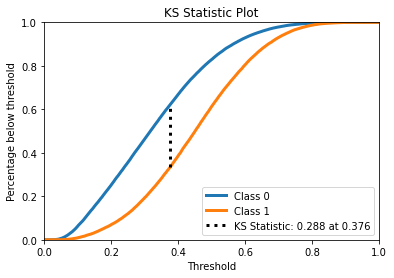

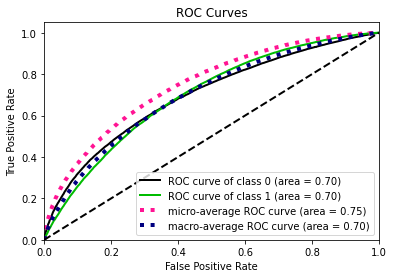

------Adaboost------
Accuracy: 0.6596
Recall: 0.4423
Precision: 0.5069
F1-Score: 0.4724
ROC AUC Score: 0.6744
Matriz de confusão no conjunto de teste:
[[49354 14421]
 [18698 14827]]


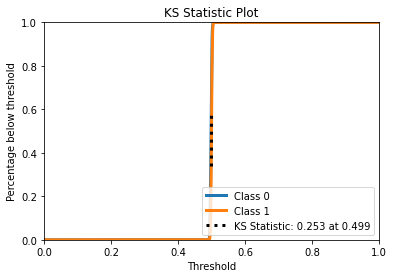

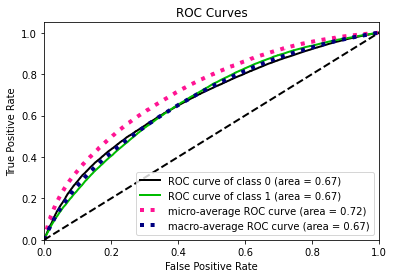

------Gradient Boosting------
Accuracy: 0.6933
Recall: 0.3794
Precision: 0.5847
F1-Score: 0.4602
ROC AUC Score: 0.7143
Matriz de confusão no conjunto de teste:
[[54739  9036]
 [20804 12721]]


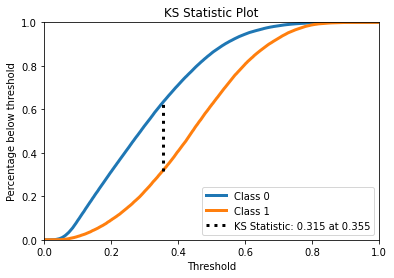

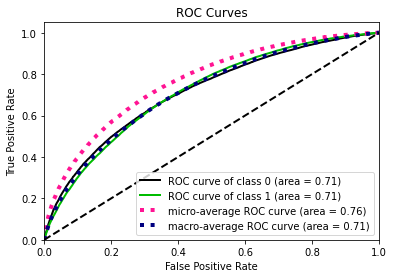

In [216]:
print("------MLP------")
print_metrics(y_test, y_pred_test_mlp, y_pred_test_proba_mlp)

print("------SVM------")
print_metrics(y_test, y_test_pred_svm, y_test_proba_svm)

print("------Random Forest------")
print_metrics(y_test, y_pred_test_rf, y_pred_test_proba_rf)

print("------Ensemble MLP------")
print_metrics(y_test, y_mlp_ens_pred_test, y_mlp_ens_pred_test_proba)

print("------Adaboost------")
print_metrics(y_test, y_test_pred_adaBoost, y_test_proba_adaBoost)

print("------Gradient Boosting------")
print_metrics(y_test, y_pred_test_gb, y_pred_test_proba_gb)

# Anexos

Descrição dos parâmetros:

- n_estimators
  - O número de árvores na floresta.


In [93]:
%pip install --user tensorflow

Note: you may need to restart the kernel to use updated packages.


In [94]:
from keras.wrappers.scikit_learn import KerasClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

#### 1ª Configuração

A primeira configuração é utilizada com os parâmetros padrões do Sklearn.

Segue abaixo a lista dos principais hiperparâmetros:

- n_

In [95]:
def create_sklearn_compatible_model():
    input_dim = X_train.shape[1]
    
    model = Sequential()
    model.add(Dense(20, activation='tanh', input_dim=input_dim))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [96]:
clf_mlp = KerasClassifier(build_fn=create_sklearn_compatible_model, 
                          batch_size=64, epochs=100,
                          verbose=0)


C:\Users\jonat\AppData\Local\Temp\ipykernel_20704\3075366852.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf_mlp = KerasClassifier(build_fn=create_sklearn_compatible_model,


In [97]:
%%time
clf_mlp.fit(X_train, y_train)

CPU times: total: 2min 18s
Wall time: 4min 59s


In [98]:
y_pred_mlp = clf_mlp.predict(X_valid)

3986/3986 [==============================] - 3s 655us/step


In [99]:
y_proba_mlp = clf_mlp.predict_proba(X_valid)

3986/3986 [==============================] - 2s 614us/step


##### Análise de Desempenho

Métricas da 1ª configuração do Random Forest:

Accuracy: 0.7325
Recall: 0.6667
Precision: 0.7678
F1-Score: 0.7136
ROC AUC Score: 0.8159
Matriz de confusão no conjunto de teste:
[[50914 12860]
 [21259 42515]]


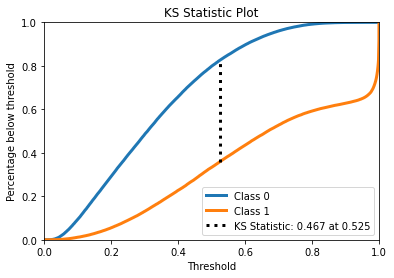

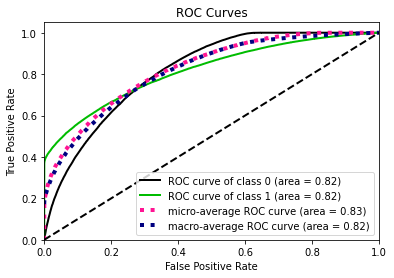

In [100]:
print('Métricas da 1ª configuração do Random Forest:\n')
print_metrics(y_valid, y_pred_mlp, y_proba_mlp)

#### 2ª Configuração

Para a segunda configuração alteramos os seguintes parâmetros:

#### Random Forest usando K-fold Cross Validation

Não teremos mais isso

In [101]:
from sklearn.model_selection import KFold

scores = []
# cv = KFold(n_splits=10, random_state=42, shuffle=True)
kfold = KFold(n_splits=3, shuffle=True)

# for train_index, test_index in cv.split(X_train):
#     print("TRAIN:", train_index, "TEST:", test_index, "LEN:", X_train.loc[255096:255097])
#     X_train2, X_test2, y_train2, y_test2 = X_train[train_index], X_train[test_index], y_train[train_index], y_train[test_index]
#     clf_rf.fit(X_train2, y_train2)
#     scores.append(clf_rf.score(X_test2, y_test2))

In [102]:
from sklearn.model_selection import cross_val_score

cross_val_score(clf_rf, X_train, y_train, cv=kfold, scoring='accuracy')

array([0.76110451, 0.75957569, 0.76192492])